<a href="https://colab.research.google.com/github/ReemAbdelhaleemHassan/Modulation-classification/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1B3EHy5dADfT2I5ewjzqVcBxw--0v6xaN/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('RML2016.10b.tar.bz2')

In [ ]:
import tarfile
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from tqdm import tqdm
from collections import defaultdict

In [ ]:
!tar -xf RML2016.10b.tar.bz2 -C '/content/'

In [ ]:
with open("RML2016.10b.dat", 'rb') as f:
    data = pickle.load(f, encoding="latin1") 

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])

In [ ]:
print(mods)
print(snrs)

In [ ]:
modulation_map = {
    '8PSK': 0,
    'AM-DSB': 1,
    'BPSK': 2,
    'CPFSK': 3,
    'GFSK': 4,
    'PAM4': 5,
    'QAM16': 6,
    'QAM64': 7,
    'QPSK': 8,
    'WBFM': 9
}

In [ ]:
dataset = []
labels = []

for mod in mods:
    for snr in snrs:
        dataset.append(data[(mod,snr)])
        for i in range(data[(mod,snr)].shape[0]):  labels.append((modulation_map[mod],snr))
dataset = np.vstack(dataset)
labels = np.asarray(labels) 

In [ ]:
print(dataset.shape)
print(labels.shape)

(1200000, 2, 128)
(1200000, 2)


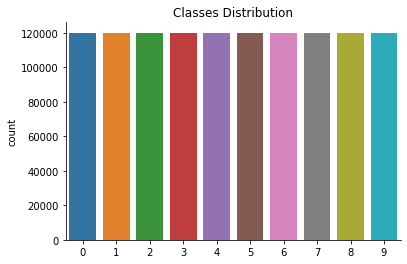

In [ ]:
plt.title("Classes Distribution")
sns.countplot(x = labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

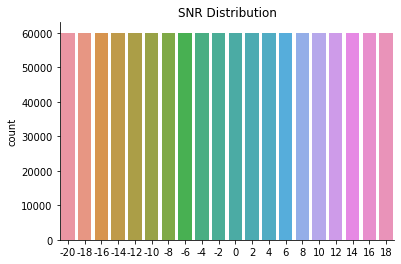

In [ ]:
plt.title("SNR Distribution")
sns.countplot(x = labels[:,1])
sns.despine(top = True, right = True, left = False, bottom = False)

# each class has 6k samples from the same SNR

In [ ]:
def visualize(mod,snr):
  plt.figure(1)
  plt.title(mod + " SNR = " + str(snr))
  plt.plot(data[(mod,snr)][0][0])
  plt.plot(data[(mod,snr)][0][1])
  plt.show()

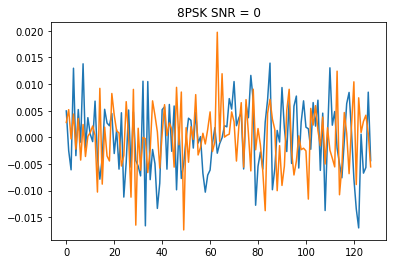

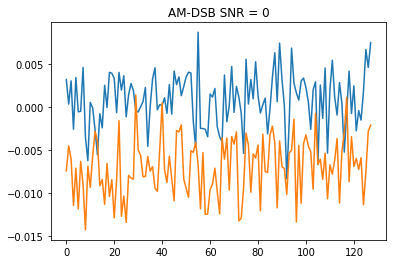

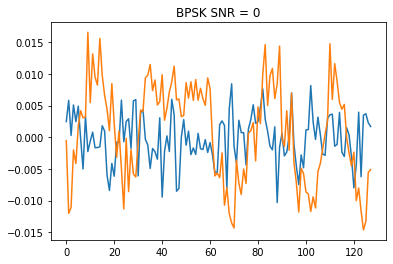

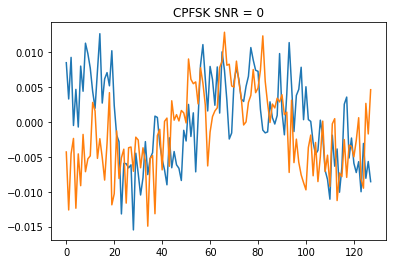

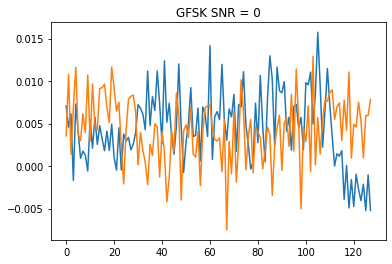

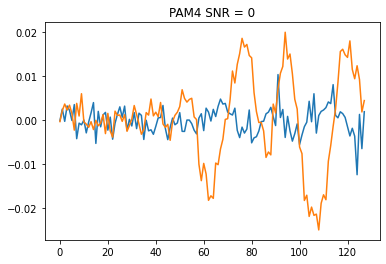

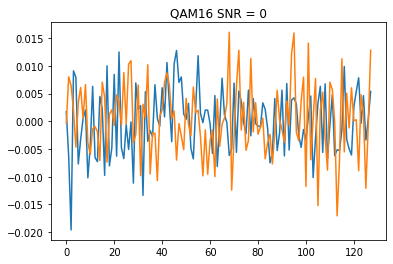

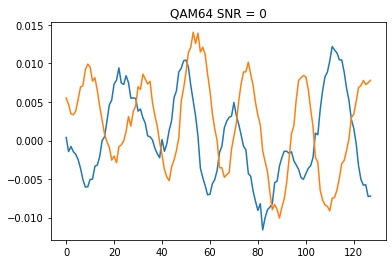

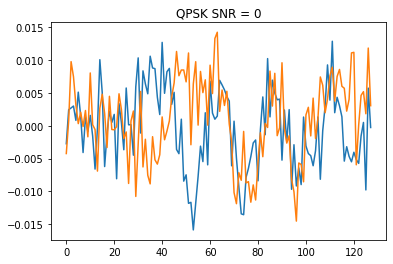

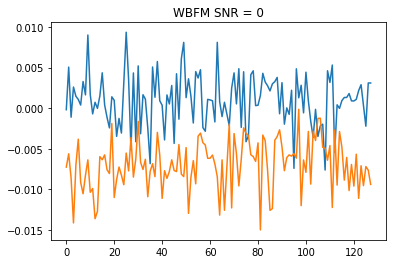

In [ ]:
# ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
visualize("8PSK",0)
visualize("AM-DSB",0)
visualize("BPSK",0)
visualize("CPFSK",0)
visualize("GFSK",0)
visualize("PAM4",0)
visualize("QAM16",0)
visualize("QAM64",0)
visualize("QPSK",0)
visualize("WBFM",0)

In [ ]:
combined_dataset = np.empty((dataset.shape[0],dataset.shape[1],3*dataset.shape[2]),dtype=np.float32)
for i in range(dataset.shape[0]):
  combined_dataset[i] = np.array([np.append(dataset[i][0],np.append(np.gradient(dataset[i][0]),
                                                                    integrate.cumtrapz(dataset[i][0],initial=0))),
                                  np.append(dataset[i][0],np.append(np.gradient(dataset[i][1]),
                                                                    integrate.cumtrapz(dataset[i][1],initial=0)))])

# for memory efficiency 
del dataset
del data

In [ ]:
combined_dataset.shape

(1200000, 2, 384)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(combined_dataset,labels, test_size=0.3, 
                                                                            random_state=42,stratify=labels)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.05, 
                                                                          random_state=42,stratify=train_labels)
del combined_dataset

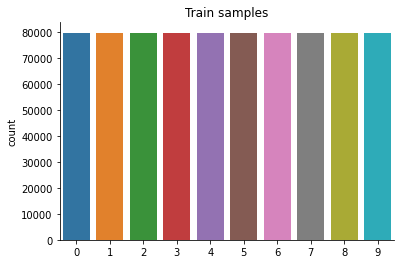

In [ ]:
plt.title("Train samples")
sns.countplot(x = train_labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

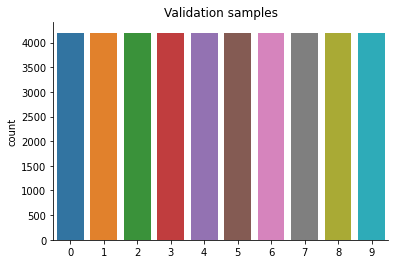

In [ ]:
plt.title("Validation samples")
sns.countplot(x = val_labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

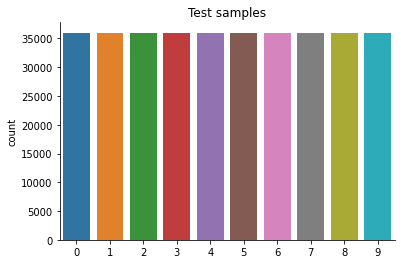

In [ ]:
plt.title("Test samples")
sns.countplot(x = test_labels[:,0])
sns.despine(top = True, right = True, left = False, bottom = False)

In [ ]:
print(train_labels[0])

[ 1 16]


In [ ]:
class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(self.feat_arr[index]).float(),torch.tensor((self.label[index]))
    #TODO
  def __len__(self):
    return len(self.feat_arr)

In [ ]:
BATCH_SIZE = 64
train_dataset = dataset(train_features,train_labels[:,0])

# TODO what is num_worker do
train_dataloader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
val_dataset = dataset(val_features,val_labels[:,0])

# TODO what is num_worker do
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
test_dataset = dataset(test_features,test_labels[:,0])

# TODO what is num_worker do
test_dataloader = DataLoader(test_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
input_size = train_features[0].shape[-1]
hidden_size = 1024
num_layers = 8
sequence_len = 2
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(train_features[0].shape)

(2, 384)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,nonlinearity="relu")
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):

        # Set initial hidden states (and cell states for LSTM) 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 2, 3*128), h0: (4, n, 256)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 2, 384)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 384)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 50

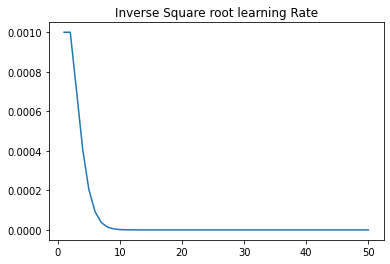

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
alpha = [LEARNING_RATE]
for i in range(len(x_axis)-1):
  alpha.append(alpha[-1]/(x_axis[i] ** 0.5))

plt.figure()
plt.title("Inverse Square root learning Rate")
plt.plot(x_axis, alpha)

In [ ]:
def train_model(model, train_dataloader, val_dataloader):
    
    
    # to store the results
    summary = defaultdict(list)
    # to select GPU for running
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # identifying the loss and optimizer funtions for weights calculations
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

    # to apply the gpu for the model and loss functions
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):
            total_acc_train = 0
            total_loss_train = 0

            for inputs, labels in tqdm(train_dataloader):

                optimizer.zero_grad()
                train_labels = labels.to(device)
                train_inputs = inputs.to(device)

                output = model(train_inputs)
                
                batch_loss = criterion(output, train_labels)
                total_loss_train += float(batch_loss.item())
                
                acc = (output.argmax(dim=1) == train_labels).sum().item()
                total_acc_train += float(acc)
                del acc


                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
                # scheduler.step()

            total_acc_val = 0
            total_loss_val = 0

            # Disabling gradient calculation is useful for inference to avoid dependency
            with torch.no_grad():

                # repreat for the previous but for the validation set 
                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += float(batch_loss.item())
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += float(acc)
                    del acc
                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_features): .3f} | Train Accuracy: {total_acc_train / len(train_features): .3f} | Val Loss: {total_loss_val / len(val_features): .3f} | Val Accuracy: {total_acc_val / len(val_features): .3f}')
            

            summary['train_acc'].append(total_acc_train/len(train_features))
            summary['train_loss'].append(total_loss_train/len(train_features))
            summary['val_acc'].append(total_acc_val/len(val_features))
            summary['val_loss'].append(total_loss_val/len(val_features))

    return model,summary

In [ ]:
model,history = train_model(model,train_dataloader,val_dataloader)

100%|██████████| 49875/49875 [02:19<00:00, 356.38it/s]


Epochs: 1 | Train Loss:  0.114 | Train Accuracy:  0.273 | Val Loss:  0.106 | Val Accuracy:  0.316


100%|██████████| 49875/49875 [02:20<00:00, 355.00it/s]


Epochs: 2 | Train Loss:  0.104 | Train Accuracy:  0.328 | Val Loss:  0.101 | Val Accuracy:  0.338


100%|██████████| 49875/49875 [02:20<00:00, 355.53it/s]


Epochs: 3 | Train Loss:  0.100 | Train Accuracy:  0.349 | Val Loss:  0.099 | Val Accuracy:  0.350


100%|██████████| 49875/49875 [02:23<00:00, 346.56it/s]


Epochs: 4 | Train Loss:  0.098 | Train Accuracy:  0.362 | Val Loss:  0.097 | Val Accuracy:  0.361


100%|██████████| 49875/49875 [02:22<00:00, 350.22it/s]


Epochs: 5 | Train Loss:  0.096 | Train Accuracy:  0.372 | Val Loss:  0.095 | Val Accuracy:  0.377


100%|██████████| 49875/49875 [02:20<00:00, 354.71it/s]


Epochs: 6 | Train Loss:  0.095 | Train Accuracy:  0.381 | Val Loss:  0.095 | Val Accuracy:  0.386


100%|██████████| 49875/49875 [02:21<00:00, 352.77it/s]


Epochs: 7 | Train Loss:  0.094 | Train Accuracy:  0.387 | Val Loss:  0.093 | Val Accuracy:  0.391


100%|██████████| 49875/49875 [02:18<00:00, 359.47it/s]


Epochs: 8 | Train Loss:  0.093 | Train Accuracy:  0.391 | Val Loss:  0.092 | Val Accuracy:  0.393


100%|██████████| 49875/49875 [02:17<00:00, 362.83it/s]


Epochs: 9 | Train Loss:  0.092 | Train Accuracy:  0.396 | Val Loss:  0.093 | Val Accuracy:  0.388


100%|██████████| 49875/49875 [02:17<00:00, 361.59it/s]


Epochs: 10 | Train Loss:  0.091 | Train Accuracy:  0.400 | Val Loss:  0.093 | Val Accuracy:  0.385


100%|██████████| 49875/49875 [02:16<00:00, 364.95it/s]


Epochs: 11 | Train Loss:  0.091 | Train Accuracy:  0.404 | Val Loss:  0.091 | Val Accuracy:  0.407


100%|██████████| 49875/49875 [02:16<00:00, 365.24it/s]


Epochs: 12 | Train Loss:  0.090 | Train Accuracy:  0.408 | Val Loss:  0.090 | Val Accuracy:  0.409


100%|██████████| 49875/49875 [02:17<00:00, 363.25it/s]


Epochs: 13 | Train Loss:  0.089 | Train Accuracy:  0.411 | Val Loss:  0.090 | Val Accuracy:  0.408


100%|██████████| 49875/49875 [02:18<00:00, 360.40it/s]


Epochs: 14 | Train Loss:  0.089 | Train Accuracy:  0.414 | Val Loss:  0.090 | Val Accuracy:  0.414


100%|██████████| 49875/49875 [02:20<00:00, 354.56it/s]


Epochs: 15 | Train Loss:  0.088 | Train Accuracy:  0.417 | Val Loss:  0.088 | Val Accuracy:  0.420


100%|██████████| 49875/49875 [02:18<00:00, 360.37it/s]


Epochs: 16 | Train Loss:  0.088 | Train Accuracy:  0.419 | Val Loss:  0.090 | Val Accuracy:  0.408


100%|██████████| 49875/49875 [02:18<00:00, 359.21it/s]


Epochs: 17 | Train Loss:  0.087 | Train Accuracy:  0.422 | Val Loss:  0.089 | Val Accuracy:  0.408


100%|██████████| 49875/49875 [02:18<00:00, 360.71it/s]


Epochs: 18 | Train Loss:  0.087 | Train Accuracy:  0.424 | Val Loss:  0.089 | Val Accuracy:  0.421


100%|██████████| 49875/49875 [02:18<00:00, 360.20it/s]


Epochs: 19 | Train Loss:  0.087 | Train Accuracy:  0.425 | Val Loss:  0.087 | Val Accuracy:  0.429


100%|██████████| 49875/49875 [02:18<00:00, 359.74it/s]


Epochs: 20 | Train Loss:  0.087 | Train Accuracy:  0.426 | Val Loss:  0.088 | Val Accuracy:  0.425


100%|██████████| 49875/49875 [02:18<00:00, 359.82it/s]


Epochs: 21 | Train Loss:  0.086 | Train Accuracy:  0.429 | Val Loss:  0.087 | Val Accuracy:  0.425


100%|██████████| 49875/49875 [02:19<00:00, 358.59it/s]


Epochs: 22 | Train Loss:  0.086 | Train Accuracy:  0.429 | Val Loss:  0.087 | Val Accuracy:  0.427


100%|██████████| 49875/49875 [02:18<00:00, 360.57it/s]


Epochs: 23 | Train Loss:  0.086 | Train Accuracy:  0.430 | Val Loss:  0.086 | Val Accuracy:  0.427


100%|██████████| 49875/49875 [02:17<00:00, 361.43it/s]


Epochs: 24 | Train Loss:  0.086 | Train Accuracy:  0.431 | Val Loss:  0.086 | Val Accuracy:  0.438


100%|██████████| 49875/49875 [02:17<00:00, 363.25it/s]


Epochs: 25 | Train Loss:  0.086 | Train Accuracy:  0.432 | Val Loss:  0.087 | Val Accuracy:  0.427


100%|██████████| 49875/49875 [02:17<00:00, 362.75it/s]


Epochs: 26 | Train Loss:  0.085 | Train Accuracy:  0.433 | Val Loss:  0.086 | Val Accuracy:  0.436


100%|██████████| 49875/49875 [02:17<00:00, 363.67it/s]


Epochs: 27 | Train Loss:  0.085 | Train Accuracy:  0.433 | Val Loss:  0.086 | Val Accuracy:  0.431


100%|██████████| 49875/49875 [02:18<00:00, 361.03it/s]


Epochs: 28 | Train Loss:  0.085 | Train Accuracy:  0.434 | Val Loss:  0.085 | Val Accuracy:  0.439


100%|██████████| 49875/49875 [02:17<00:00, 362.79it/s]


Epochs: 29 | Train Loss:  0.085 | Train Accuracy:  0.436 | Val Loss:  0.087 | Val Accuracy:  0.435


100%|██████████| 49875/49875 [02:17<00:00, 362.57it/s]


Epochs: 30 | Train Loss:  0.085 | Train Accuracy:  0.436 | Val Loss:  0.086 | Val Accuracy:  0.432


100%|██████████| 49875/49875 [02:17<00:00, 361.58it/s]


Epochs: 31 | Train Loss:  0.085 | Train Accuracy:  0.437 | Val Loss:  0.086 | Val Accuracy:  0.429


100%|██████████| 49875/49875 [02:17<00:00, 363.37it/s]


Epochs: 32 | Train Loss:  0.085 | Train Accuracy:  0.437 | Val Loss:  0.085 | Val Accuracy:  0.442


100%|██████████| 49875/49875 [02:21<00:00, 353.70it/s]


Epochs: 33 | Train Loss:  0.085 | Train Accuracy:  0.438 | Val Loss:  0.085 | Val Accuracy:  0.443


100%|██████████| 49875/49875 [02:20<00:00, 355.39it/s]


Epochs: 34 | Train Loss:  0.085 | Train Accuracy:  0.439 | Val Loss:  0.085 | Val Accuracy:  0.441


100%|██████████| 49875/49875 [02:20<00:00, 354.89it/s]


Epochs: 35 | Train Loss:  0.085 | Train Accuracy:  0.439 | Val Loss:  0.085 | Val Accuracy:  0.433


100%|██████████| 49875/49875 [02:16<00:00, 364.06it/s]


Epochs: 36 | Train Loss:  0.085 | Train Accuracy:  0.439 | Val Loss:  0.086 | Val Accuracy:  0.433


100%|██████████| 49875/49875 [02:16<00:00, 364.35it/s]


Epochs: 37 | Train Loss:  0.084 | Train Accuracy:  0.440 | Val Loss:  0.085 | Val Accuracy:  0.435


100%|██████████| 49875/49875 [02:16<00:00, 365.35it/s]


Epochs: 38 | Train Loss:  0.084 | Train Accuracy:  0.440 | Val Loss:  0.085 | Val Accuracy:  0.443


100%|██████████| 49875/49875 [02:16<00:00, 364.28it/s]


Epochs: 39 | Train Loss:  0.084 | Train Accuracy:  0.441 | Val Loss:  0.085 | Val Accuracy:  0.437


100%|██████████| 49875/49875 [02:16<00:00, 364.70it/s]


Epochs: 40 | Train Loss:  0.084 | Train Accuracy:  0.441 | Val Loss:  0.086 | Val Accuracy:  0.436


100%|██████████| 49875/49875 [02:16<00:00, 365.45it/s]


Epochs: 41 | Train Loss:  0.084 | Train Accuracy:  0.441 | Val Loss:  0.085 | Val Accuracy:  0.436


100%|██████████| 49875/49875 [02:16<00:00, 364.49it/s]


Epochs: 42 | Train Loss:  0.084 | Train Accuracy:  0.441 | Val Loss:  0.085 | Val Accuracy:  0.442


100%|██████████| 49875/49875 [02:16<00:00, 364.64it/s]


Epochs: 43 | Train Loss:  0.084 | Train Accuracy:  0.442 | Val Loss:  0.085 | Val Accuracy:  0.437


100%|██████████| 49875/49875 [02:16<00:00, 364.80it/s]


Epochs: 44 | Train Loss:  0.084 | Train Accuracy:  0.441 | Val Loss:  0.085 | Val Accuracy:  0.440


100%|██████████| 49875/49875 [02:16<00:00, 364.73it/s]


Epochs: 45 | Train Loss:  0.084 | Train Accuracy:  0.443 | Val Loss:  0.085 | Val Accuracy:  0.435


100%|██████████| 49875/49875 [02:16<00:00, 364.21it/s]


Epochs: 46 | Train Loss:  0.084 | Train Accuracy:  0.442 | Val Loss:  0.085 | Val Accuracy:  0.441


100%|██████████| 49875/49875 [02:16<00:00, 364.99it/s]


Epochs: 47 | Train Loss:  0.084 | Train Accuracy:  0.443 | Val Loss:  0.084 | Val Accuracy:  0.444


100%|██████████| 49875/49875 [02:17<00:00, 363.86it/s]


Epochs: 48 | Train Loss:  0.084 | Train Accuracy:  0.443 | Val Loss:  0.085 | Val Accuracy:  0.442


100%|██████████| 49875/49875 [02:17<00:00, 363.49it/s]


Epochs: 49 | Train Loss:  0.084 | Train Accuracy:  0.443 | Val Loss:  0.085 | Val Accuracy:  0.436


100%|██████████| 49875/49875 [02:17<00:00, 363.68it/s]


Epochs: 50 | Train Loss:  0.084 | Train Accuracy:  0.443 | Val Loss:  0.085 | Val Accuracy:  0.433


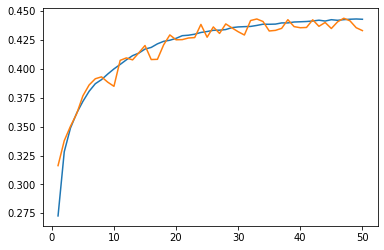

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
plt.plot(x_axis, history['train_acc'])
plt.plot(x_axis, history['val_acc'])

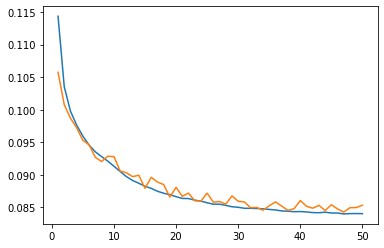

In [ ]:
plt.plot(x_axis, history['train_loss'])
plt.plot(x_axis, history['val_loss'])

In [ ]:
model,history = train_model(model,train_dataloader,val_dataloader)

100%|██████████| 12469/12469 [01:27<00:00, 142.24it/s]


Epochs: 1 | Train Loss:  0.024 | Train Accuracy:  0.347 | Val Loss:  0.045 | Val Accuracy:  0.397


100%|██████████| 12469/12469 [01:27<00:00, 142.35it/s]


Epochs: 2 | Train Loss:  0.021 | Train Accuracy:  0.426 | Val Loss:  0.041 | Val Accuracy:  0.446


100%|██████████| 12469/12469 [01:27<00:00, 142.54it/s]


Epochs: 3 | Train Loss:  0.020 | Train Accuracy:  0.461 | Val Loss:  0.039 | Val Accuracy:  0.474


100%|██████████| 12469/12469 [01:27<00:00, 142.46it/s]


Epochs: 4 | Train Loss:  0.019 | Train Accuracy:  0.481 | Val Loss:  0.039 | Val Accuracy:  0.480


100%|██████████| 12469/12469 [01:27<00:00, 142.54it/s]


Epochs: 5 | Train Loss:  0.019 | Train Accuracy:  0.491 | Val Loss:  0.038 | Val Accuracy:  0.495


100%|██████████| 12469/12469 [01:27<00:00, 142.62it/s]


Epochs: 6 | Train Loss:  0.019 | Train Accuracy:  0.500 | Val Loss:  0.037 | Val Accuracy:  0.498


100%|██████████| 12469/12469 [01:27<00:00, 142.03it/s]


Epochs: 7 | Train Loss:  0.019 | Train Accuracy:  0.505 | Val Loss:  0.037 | Val Accuracy:  0.502


100%|██████████| 12469/12469 [01:27<00:00, 142.42it/s]


Epochs: 8 | Train Loss:  0.018 | Train Accuracy:  0.510 | Val Loss:  0.037 | Val Accuracy:  0.504


100%|██████████| 12469/12469 [01:27<00:00, 142.56it/s]


Epochs: 9 | Train Loss:  0.018 | Train Accuracy:  0.513 | Val Loss:  0.037 | Val Accuracy:  0.501


100%|██████████| 12469/12469 [01:27<00:00, 142.36it/s]


Epochs: 10 | Train Loss:  0.018 | Train Accuracy:  0.516 | Val Loss:  0.037 | Val Accuracy:  0.505


100%|██████████| 12469/12469 [01:27<00:00, 142.32it/s]


Epochs: 11 | Train Loss:  0.018 | Train Accuracy:  0.519 | Val Loss:  0.037 | Val Accuracy:  0.511


100%|██████████| 12469/12469 [01:27<00:00, 142.81it/s]


Epochs: 12 | Train Loss:  0.018 | Train Accuracy:  0.516 | Val Loss:  0.037 | Val Accuracy:  0.509


100%|██████████| 12469/12469 [01:27<00:00, 142.49it/s]


Epochs: 13 | Train Loss:  0.018 | Train Accuracy:  0.523 | Val Loss:  0.037 | Val Accuracy:  0.509


100%|██████████| 12469/12469 [01:27<00:00, 143.06it/s]


Epochs: 14 | Train Loss:  0.018 | Train Accuracy:  0.525 | Val Loss:  0.036 | Val Accuracy:  0.518


100%|██████████| 12469/12469 [01:27<00:00, 142.85it/s]


Epochs: 15 | Train Loss:  0.018 | Train Accuracy:  0.526 | Val Loss:  0.036 | Val Accuracy:  0.517


100%|██████████| 12469/12469 [01:27<00:00, 143.02it/s]


Epochs: 16 | Train Loss:  0.018 | Train Accuracy:  0.528 | Val Loss:  0.036 | Val Accuracy:  0.515


100%|██████████| 12469/12469 [01:27<00:00, 143.10it/s]


Epochs: 17 | Train Loss:  0.018 | Train Accuracy:  0.529 | Val Loss:  0.037 | Val Accuracy:  0.513


100%|██████████| 12469/12469 [01:27<00:00, 142.91it/s]


Epochs: 18 | Train Loss:  0.018 | Train Accuracy:  0.531 | Val Loss:  0.037 | Val Accuracy:  0.510


100%|██████████| 12469/12469 [01:27<00:00, 142.84it/s]


Epochs: 19 | Train Loss:  0.019 | Train Accuracy:  0.516 | Val Loss:  0.037 | Val Accuracy:  0.513


100%|██████████| 12469/12469 [01:27<00:00, 142.92it/s]


Epochs: 20 | Train Loss:  0.018 | Train Accuracy:  0.530 | Val Loss:  0.037 | Val Accuracy:  0.500


100%|██████████| 12469/12469 [01:27<00:00, 142.49it/s]


Epochs: 21 | Train Loss:  0.018 | Train Accuracy:  0.532 | Val Loss:  0.037 | Val Accuracy:  0.515


100%|██████████| 12469/12469 [01:27<00:00, 142.64it/s]


Epochs: 22 | Train Loss:  0.017 | Train Accuracy:  0.534 | Val Loss:  0.036 | Val Accuracy:  0.519


100%|██████████| 12469/12469 [01:27<00:00, 142.83it/s]


Epochs: 23 | Train Loss:  0.018 | Train Accuracy:  0.534 | Val Loss:  0.036 | Val Accuracy:  0.516


100%|██████████| 12469/12469 [01:27<00:00, 142.84it/s]


Epochs: 24 | Train Loss:  0.017 | Train Accuracy:  0.533 | Val Loss:  0.036 | Val Accuracy:  0.517


100%|██████████| 12469/12469 [01:27<00:00, 142.84it/s]


Epochs: 25 | Train Loss:  0.017 | Train Accuracy:  0.536 | Val Loss:  0.037 | Val Accuracy:  0.511


100%|██████████| 12469/12469 [01:27<00:00, 142.89it/s]


Epochs: 26 | Train Loss:  0.017 | Train Accuracy:  0.536 | Val Loss:  0.036 | Val Accuracy:  0.517


100%|██████████| 12469/12469 [01:27<00:00, 142.72it/s]


Epochs: 27 | Train Loss:  0.017 | Train Accuracy:  0.538 | Val Loss:  0.036 | Val Accuracy:  0.518


100%|██████████| 12469/12469 [01:27<00:00, 142.97it/s]


Epochs: 28 | Train Loss:  0.018 | Train Accuracy:  0.533 | Val Loss:  0.036 | Val Accuracy:  0.523


100%|██████████| 12469/12469 [01:27<00:00, 142.69it/s]


Epochs: 29 | Train Loss:  0.017 | Train Accuracy:  0.538 | Val Loss:  0.036 | Val Accuracy:  0.519


100%|██████████| 12469/12469 [01:27<00:00, 142.43it/s]


Epochs: 30 | Train Loss:  0.017 | Train Accuracy:  0.539 | Val Loss:  0.036 | Val Accuracy:  0.520


100%|██████████| 12469/12469 [01:27<00:00, 142.40it/s]


Epochs: 31 | Train Loss:  0.018 | Train Accuracy:  0.526 | Val Loss:  0.036 | Val Accuracy:  0.518


100%|██████████| 12469/12469 [01:27<00:00, 141.96it/s]


Epochs: 32 | Train Loss:  0.017 | Train Accuracy:  0.539 | Val Loss:  0.036 | Val Accuracy:  0.522


100%|██████████| 12469/12469 [01:27<00:00, 142.39it/s]


Epochs: 33 | Train Loss:  0.017 | Train Accuracy:  0.537 | Val Loss:  0.036 | Val Accuracy:  0.521


100%|██████████| 12469/12469 [01:27<00:00, 142.50it/s]


Epochs: 34 | Train Loss:  0.019 | Train Accuracy:  0.504 | Val Loss:  0.036 | Val Accuracy:  0.518


100%|██████████| 12469/12469 [01:27<00:00, 142.44it/s]


Epochs: 35 | Train Loss:  0.017 | Train Accuracy:  0.538 | Val Loss:  0.037 | Val Accuracy:  0.515


100%|██████████| 12469/12469 [01:27<00:00, 142.58it/s]


Epochs: 36 | Train Loss:  0.017 | Train Accuracy:  0.541 | Val Loss:  0.036 | Val Accuracy:  0.517


100%|██████████| 12469/12469 [01:27<00:00, 142.79it/s]


Epochs: 37 | Train Loss:  0.017 | Train Accuracy:  0.542 | Val Loss:  0.036 | Val Accuracy:  0.517


100%|██████████| 12469/12469 [01:27<00:00, 142.49it/s]


Epochs: 38 | Train Loss:  0.017 | Train Accuracy:  0.539 | Val Loss:  0.037 | Val Accuracy:  0.520


100%|██████████| 12469/12469 [01:27<00:00, 142.30it/s]


Epochs: 39 | Train Loss:  0.017 | Train Accuracy:  0.543 | Val Loss:  0.036 | Val Accuracy:  0.521


100%|██████████| 12469/12469 [01:28<00:00, 141.61it/s]


Epochs: 40 | Train Loss:  0.018 | Train Accuracy:  0.532 | Val Loss:  0.036 | Val Accuracy:  0.520


100%|██████████| 12469/12469 [01:28<00:00, 141.50it/s]


Epochs: 41 | Train Loss:  0.025 | Train Accuracy:  0.510 | Val Loss:  0.038 | Val Accuracy:  0.501


100%|██████████| 12469/12469 [01:27<00:00, 141.94it/s]


Epochs: 42 | Train Loss:  0.018 | Train Accuracy:  0.524 | Val Loss:  0.036 | Val Accuracy:  0.515


100%|██████████| 12469/12469 [01:27<00:00, 141.73it/s]


Epochs: 43 | Train Loss:  0.017 | Train Accuracy:  0.540 | Val Loss:  0.036 | Val Accuracy:  0.521


100%|██████████| 12469/12469 [01:27<00:00, 142.56it/s]


Epochs: 44 | Train Loss:  0.017 | Train Accuracy:  0.543 | Val Loss:  0.036 | Val Accuracy:  0.514


100%|██████████| 12469/12469 [01:27<00:00, 142.31it/s]


Epochs: 45 | Train Loss:  0.017 | Train Accuracy:  0.541 | Val Loss:  0.037 | Val Accuracy:  0.506


100%|██████████| 12469/12469 [01:27<00:00, 142.27it/s]


Epochs: 46 | Train Loss:  0.018 | Train Accuracy:  0.528 | Val Loss:  0.037 | Val Accuracy:  0.523


100%|██████████| 12469/12469 [01:27<00:00, 142.32it/s]


Epochs: 47 | Train Loss:  0.017 | Train Accuracy:  0.540 | Val Loss:  0.037 | Val Accuracy:  0.515


100%|██████████| 12469/12469 [01:27<00:00, 142.39it/s]


Epochs: 48 | Train Loss:  0.019 | Train Accuracy:  0.529 | Val Loss:  0.037 | Val Accuracy:  0.522


100%|██████████| 12469/12469 [01:27<00:00, 142.24it/s]


Epochs: 49 | Train Loss:  0.017 | Train Accuracy:  0.544 | Val Loss:  0.036 | Val Accuracy:  0.522


100%|██████████| 12469/12469 [01:27<00:00, 142.40it/s]


Epochs: 50 | Train Loss:  0.017 | Train Accuracy:  0.545 | Val Loss:  0.037 | Val Accuracy:  0.523


In [ ]:
# change number of EPOCHS here
EPOCHS = 
model,history = train_model(model,train_dataloader,val_dataloader)

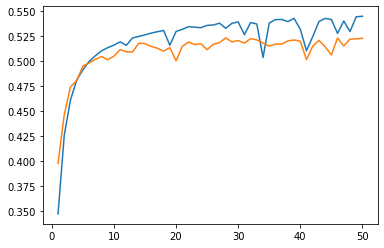

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
plt.plot(x_axis, history['train_acc'])
plt.plot(x_axis, history['val_acc'])

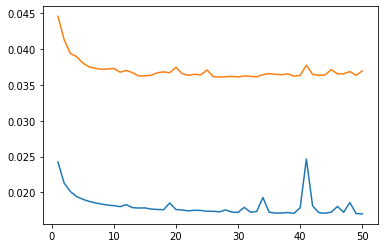

In [ ]:
plt.plot(x_axis, history['train_loss'])
plt.plot(x_axis, history['val_loss'])

In [ ]:
def test_model(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    y_pred=[]
    y_true=[]

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    # Disabling gradient calculation is useful for inference to avoid dependency
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              test_input = test_input.to(device)
              output = model(test_input)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              
              y_pred.extend((torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()) # Save Prediction
      
              test_label = test_label.data.cpu().numpy()
              y_true.extend(test_label) # Save Truth

            
    print(f'Test Accuracy: {total_acc_test / len(test_features): .3f}')
    return y_pred, y_true, total_acc_test / len(test_features)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred,y_true,total_acc = test_model(model,test_dataloader)
f1_score(y_true, y_pred, average=None)

Test Accuracy:  0.523


array([0.35287746, 0.50621511, 0.63179563, 0.67594124, 0.67936922,
       0.72676321, 0.29911932, 0.46520096, 0.4962882 , 0.48522447])

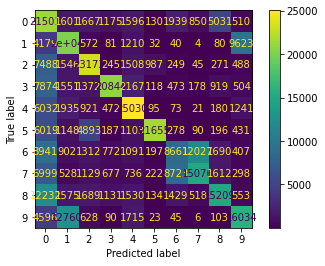

In [ ]:
confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()